# Meteorological data processing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [8]:
storm_name = '2020/0428_bourka_chotoviny'
dto = '/storage/experiments/' + storm_name + '/meteo/' #  File to Open
fto = dto + 'DATALOG.TXT'

print (fto)

l=[]
l.extend(range(0,20))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

#df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

sn = df.loc[df[0]=='$DIVISEK'][3]
print (sn[0])


/storage/experiments/2020/0428_bourka_chotoviny/meteo/DATALOG.TXT
1290c00806a20091302fa000a000004d


## Derive measurement runs in to separate files

In [10]:
try:
    os.makedirs(dto + 'output/')
except:
    pass

run = 0

runs = []
LatDD = np.nan
LonDD = np.nan
flag = 0
flagrun = 0


import re
def dm_to_sd(dm):
    '''
    Converts a geographic co-ordinate given in "degrees/minutes" dddmm.mmmm
    format (eg, "12319.943281" = 123 degrees, 19.943281 minutes) to a signed
    decimal (python float) format
    '''
    # '12319.943281'
    if dm == 'nan':
        return np.nan
    if not dm or dm == '0':
        return 0.
    d, m = re.match(r'^(\d+)(\d\d\.\d+)$', dm).groups()
    return float(d) + float(m) / 60


for i,r in df.iterrows():
    if (r[0] == '$DIVISEK'):
        run = run + 1
        date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
        time = 0
        timedelta = 0
        altitude = np.nan
        Lat = np.nan
        Lon = np.nan
        speed = np.nan
        timeoffset = np.nan
        flag = 0
        flagrun = 0
        print (run,end='')
        
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        timedelta = time
        speed = r[7]
        if (r.astype(str)[4]=='S'):     # Conferr DDMM.MM to DD.DD
            LatS = -1
        else:
            LatS = 1
        if (r.astype(str)[6]=='W'):
            LonS = -1
        else:
            LonS = 1
        LatDD = dm_to_sd(str(r[3]))
        LatDD = LatDD * LatS  
        LonDD = dm_to_sd(str(r[5]))
        LonDD = LonDD * LonS 
        if (str(r[2]) == 'A'): 
            flag = 1
            
       
    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.at[i,'date'] = date
    df.at[i,'altitude'] = altitude
    df.at[i,'speed'] = speed

    if (r[0] == '$TIME'):
        timeoffset = pd.to_numeric(r[1])
        
    if (r[0] == '$MPL'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta,altitude,LatDD,LonDD])
                flagrun = 1
            flag = 0
        #date_line = date + pd.to_timedelta(time - timeoffset - timedelta, unit='s')
        date_line = date + pd.to_timedelta(time - timeoffset, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
        df.at[i,'alt'] = altitude
        
        
    if (r[0] == '$STROKE'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
        date_line = date + pd.to_timedelta(time - timeoffset, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
        df.at[i,'alt'] = altitude
                
print()

df = df[pd.notnull(df['date'])]
dfo = df.copy()
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$DIVISEK'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$TIME'].index, inplace=True)

for f in glob.iglob(dto + 'output/*.csv'): # delete all output files 
    print ('Deleting', f)
    os.remove(f)


dfo.set_index('date', inplace = True)

for x in runs: 
    dfo.loc[dfo['run'] == x[0]].to_csv(dto + 'output/' + str(x[3]) + '_' + str(x[4]) + '_' + str(x[5]) + '_' +  str(x[1] + pd.to_timedelta(-x[2], unit='s')) + '_' + str(sn[0]) + '.csv')


1
Deleting /storage/experiments/2020/0428_bourka_chotoviny/meteo/output/481.6_49.472926666666666_14.6581335_2020-04-28 20:11:48_1290c00806a20091302fa000a000004d.csv


In [137]:
str(x[4])

'49.715369333333335'

## Plot Lightning, Precipitation, Pressure, Temperature

/nix/store/ham6sd5375nyj3s80lzfq3c6yva8fqcl-python3.7-ipykernel-5.1.1/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  from ipykernel import kernelapp as app


FileNotFoundError: [Errno 2] File b'./data/data.csv' does not exist: b'./data/data.csv'

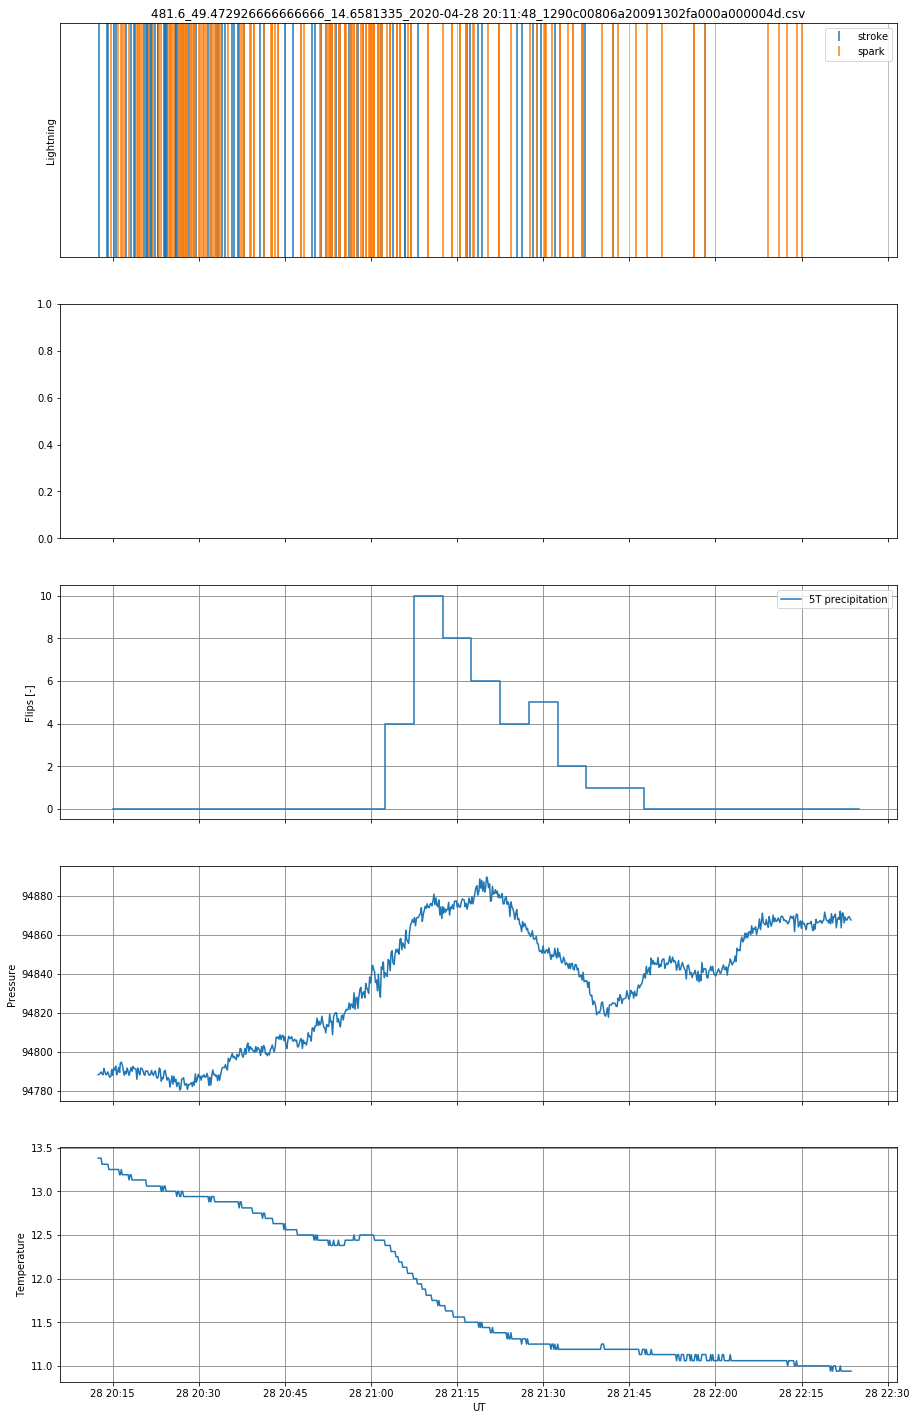

In [15]:
for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    #try:
        s = f.split('/')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$MPL'].index, inplace=True)
        
        #plt.figure(figsize=(40,40))
        #plt.tight_layout()
        
        fig, (ax1, ax5, ax2, ax3, ax4) = plt.subplots(nrows=5, sharex=True, figsize=(15,25))
        
        ax1.set_ylim(0,0)
        ax1.set_yticks([])
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==8]
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='stroke')
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==4]
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='spark')
        ax1.set_title(s[len(s)-1])
        #ax1.set_xlabel('UT')
        ax1.set_ylabel('Lightning')
        ax1.legend()
        ax1.grid()

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['3'] = pd.to_numeric(xx['3'])

        interval = '5T'
        xx = xx.resample(interval, label='right').sum()
        ax2.plot(xx['3'], drawstyle='steps-mid', label = interval + ' precipitation')
        #ax2.set_title(interval + ' - ' + s[len(s)-1])
        ax2.set_ylabel('Flips [-]')
        ax2.grid(b=True, which='major', color='grey', linestyle='-')
        ax2.locator_params(axis="y", integer=True, tight=True)
        ax2.legend()
        
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['4'] = pd.to_numeric(xx['4'])
        xx['5'] = pd.to_numeric(xx['5'])

        ax3.plot(xx['4'])
        #plt.locator_params(axis='y', nbins=6)
        ax3.grid(b=True, which='major', color='grey', linestyle='-')

        #ax3.set_title(s[len(s)-1])
        #ax3.set_xlabel('UT')
        ax3.set_ylabel('Pressure')
        #plt.legend(loc=2)

        ax4.plot(xx['5'])
        ax4.set_xlabel('UT')
        ax4.set_ylabel('Temperature')
        #plt.autoscale()       
        ax4.grid(b=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()
        
        
        df = pd.read_csv('./data/data.csv', sep=',', header=0)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df.set_index(df['timestamp'])
        ax5.plot(df['timestamp'],df['num_rec'], marker='.', linestyle='', label='RT Flux')
        df['avg'] = df['num_rec'].rolling(100).mean() 
        ax5.plot(df['timestamp'],df['avg'], label='RT Flux avg')
        #ax5.set_title('RT Flux')
        #ax5.set_xlabel('UT')
        ax5.set_ylabel(r'Counts [s$^-$$^1$]')
        ax5.grid()
        ax5.legend()

                
    #except:
        #pass



/nix/store/ham6sd5375nyj3s80lzfq3c6yva8fqcl-python3.7-ipykernel-5.1.1/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  from ipykernel import kernelapp as app


FileNotFoundError: [Errno 2] File b'./data/data.csv' does not exist: b'./data/data.csv'

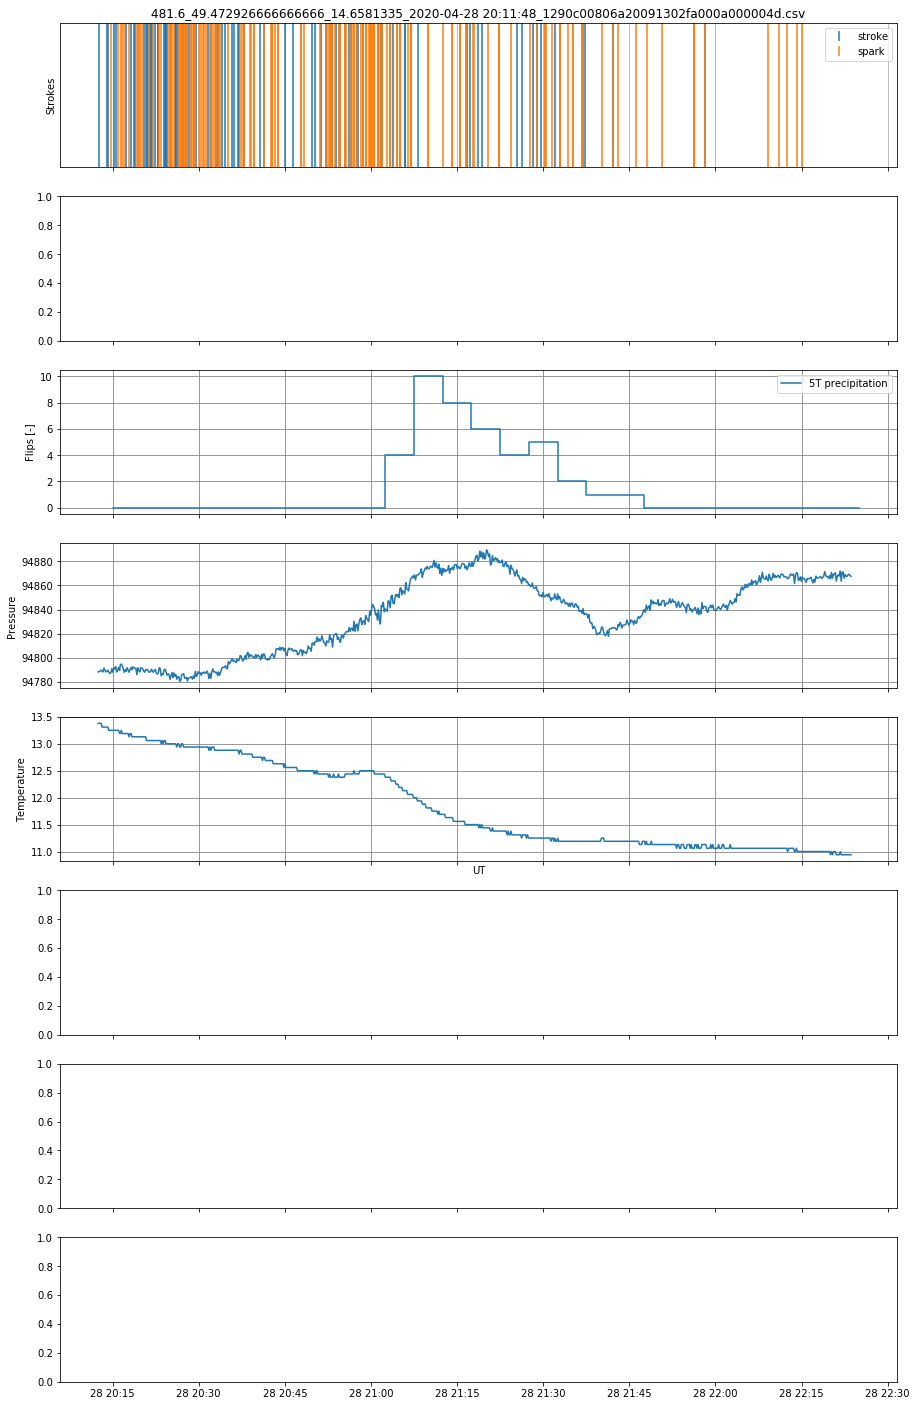

In [16]:
for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    #try:
        s = f.split('/')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$MPL'].index, inplace=True)
        
        #plt.figure(figsize=(40,40))
        #plt.tight_layout()
        
        fig, (ax1, ax5, ax2, ax3, ax4, ax6, ax7, ax8) = plt.subplots(nrows=8, sharex=True, figsize=(15,25))
        
        ax1.set_ylim(0,0)
        ax1.set_yticks([])
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==8]
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='stroke')
        xx['12'] = pd.to_numeric(xx['12'])
        xxx = xx.loc[xx['12']==4]
        ax1.errorbar(xxx.index, xxx['12'], yerr=10, marker='', linestyle='', label='spark')
        ax1.set_title(s[len(s)-1])
        #ax1.set_xlabel('UT')
        ax1.set_ylabel('Strokes')
        ax1.legend()
        ax1.grid()

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['3'] = pd.to_numeric(xx['3'])

        interval = '5T'
        xx = xx.resample(interval, label='right').sum()
        ax2.plot(xx['3'], drawstyle='steps-mid', label = interval + ' precipitation')
        #ax2.set_title(interval + ' - ' + s[len(s)-1])
        ax2.set_ylabel('Flips [-]')
        ax2.grid(b=True, which='major', color='grey', linestyle='-')
        ax2.locator_params(axis="y", integer=True, tight=True)
        ax2.legend()
        
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['4'] = pd.to_numeric(xx['4'])
        xx['5'] = pd.to_numeric(xx['5'])

        ax3.plot(xx['4'])
        #plt.locator_params(axis='y', nbins=6)
        ax3.grid(b=True, which='major', color='grey', linestyle='-')

        #ax3.set_title(s[len(s)-1])
        #ax3.set_xlabel('UT')
        ax3.set_ylabel('Pressure')
        #plt.legend(loc=2)

        ax4.plot(xx['5'])
        ax4.set_xlabel('UT')
        ax4.set_ylabel('Temperature')
        #plt.autoscale()       
        ax4.grid(b=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()
        
        
        df = pd.read_csv('./data/data.csv', sep=',', header=0)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df.set_index(df['timestamp'])
        ax5.plot(df['timestamp'],df['num_rec'], marker='.', linestyle='', label='RT Flux')
        df['avg'] = df['num_rec'].rolling(100).mean() 
        ax5.plot(df['timestamp'],df['avg'], label='RT Flux avg')
        #ax5.set_title('RT Flux')
        #ax5.set_xlabel('UT')
        ax5.set_ylabel(r'Counts [s$^-$$^1$]')
        ax5.grid()
        ax5.legend()

        ax6.plot(xx['altitude'])
        ax6.set_xlabel('UT')
        ax6.set_ylabel('Altitude')
        #plt.autoscale()       
        ax6.grid(b=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()

        ax7.plot(xx['lat'])
        ax7.set_xlabel('UT')
        ax7.set_ylabel('Latitude')
        #plt.autoscale()       
        ax7.grid(b=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()

        ax8.plot(xx['lon'])
        ax8.set_xlabel('UT')
        ax8.set_ylabel('Longitude')
        #plt.autoscale()       
        ax8.grid(b=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()

                
    #except:
        #pass



# Plot Map

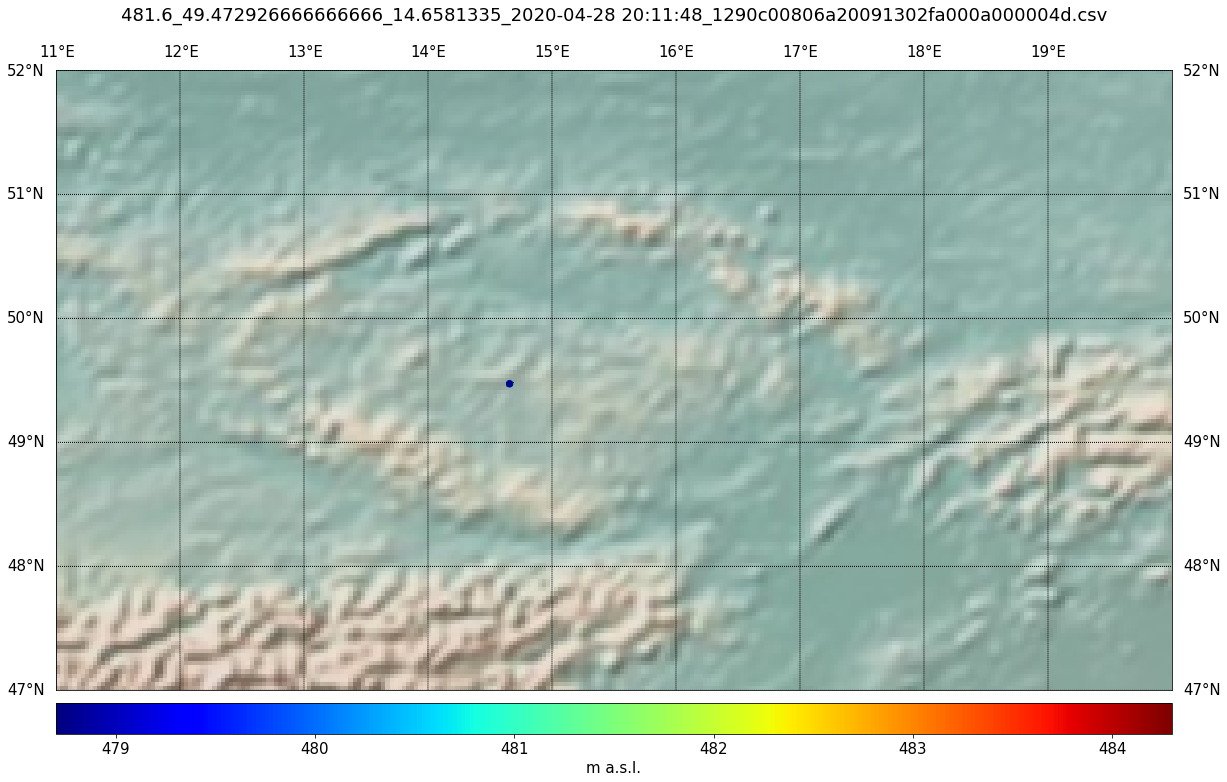

In [20]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(20,20))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        #df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        
        matplotlib.rcParams.update({'font.size': 15})

        # create Basemap instance.
        #m = Basemap(projection='kav7',lon_0=0)
        m = Basemap(projection='cyl',lon_0=0, llcrnrlon=11,llcrnrlat=47,urcrnrlon=20,urcrnrlat=52)
        #m = Basemap(projection='robin',lon_0=0)
        #m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        #m.drawmapboundary(fill_color='#99ffff')
        #m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
        # draw parallels and meridians, but don't bother labelling them.
        m.drawparallels(np.arange(0.,99.,1.),labels=[1,1,0,0])
        m.drawmeridians(np.arange(0.,20.,1.),labels=[0,0,1,0])
        m.shadedrelief()
        
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('m a.s.l.')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        #plt.clim(0, 12500)  # limit for color axis
        plt.show()                
    except:
        pass


## Plot Street Map

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1625264.5655817944,6310546.672185574,1636396.5146611212,6327621.186434159&bboxSR=3395&imageSR=3395&size=400,613&dpi=96&format=png32&transparent=true&f=image


<Figure size 720x720 with 0 Axes>

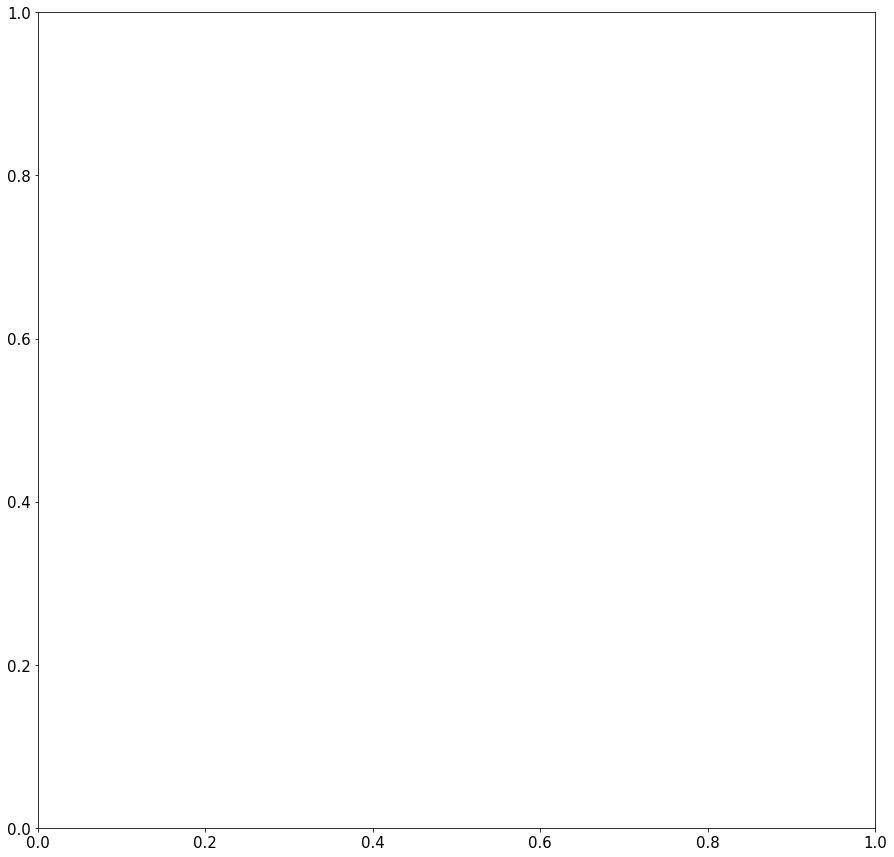

In [23]:
plt.figure(figsize=(10,10))
matplotlib.rcParams.update({'font.size': 15})

import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

for f in glob.iglob(dto + 'output/*.csv'): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,15))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        #df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
               
        matplotlib.rcParams.update({'font.size': 15})

        m = Basemap(llcrnrlon=14.6,llcrnrlat=49.4,urcrnrlon=14.7, urcrnrlat=49.5,  epsg = 3395,resolution='i',projection='merc')
        #m = Basemap(llcrnrlon=15.25,llcrnrlat=50.1,urcrnrlon=15.5, urcrnrlat=50.2, epsg = 31284)
 
        m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 400, verbose= True)

        x, y = m(df6.lon.tolist(),df6.lat.tolist())

        m.drawparallels(np.arange(0.,99.,0.02),labels=[1,1,0,0])
        m.drawmeridians(np.arange(0.,20.,0.05),labels=[0,0,1,0])
        
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('m a.s.l.')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.show() 
    except:
        pass


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1598547.88779,6455077.44837,1600774.27761,6456813.37415&bboxSR=3395&imageSR=3395&size=800,623&dpi=96&format=png32&transparent=true&f=image


<Figure size 720x720 with 0 Axes>

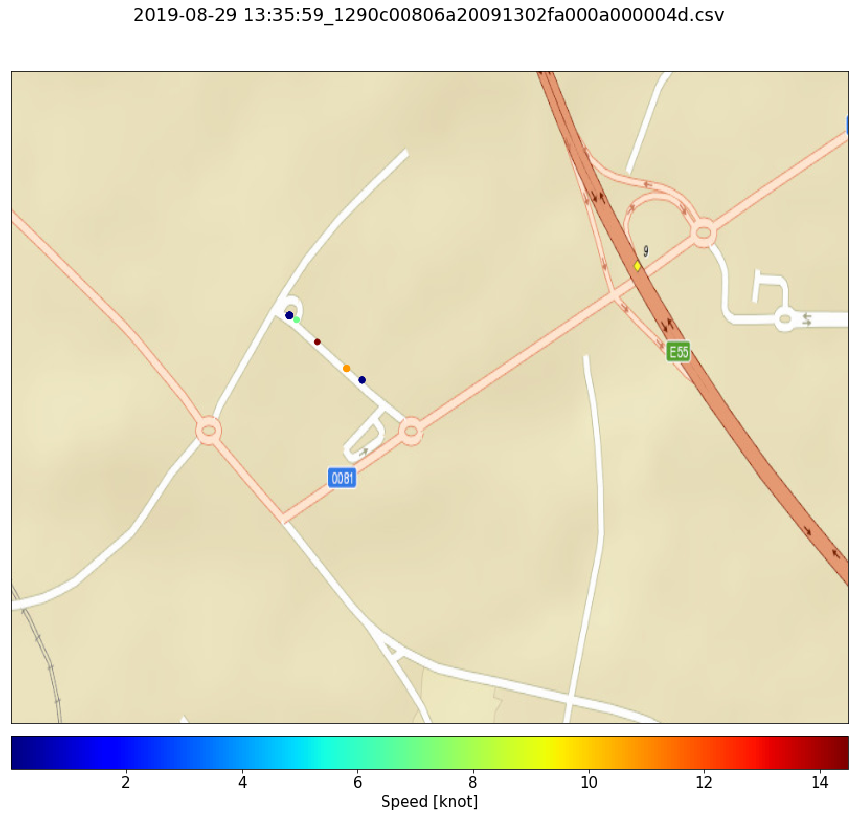

In [52]:
plt.figure(figsize=(10,10))

import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,15))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        #df6.dropna(inplace=True)
        df6.set_index('date', inplace = True)
        df6 = df6.loc['2019-08-29 14:12':'2019-08-29 14:14']
        
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['speed'] = pd.to_numeric(df6['speed'])
               
        matplotlib.rcParams.update({'font.size': 15})

        m = Basemap(llcrnrlon=14.36,llcrnrlat=50.24,urcrnrlon=14.38, urcrnrlat=50.25,  epsg = 3395,resolution='i',projection='merc')
        #m = Basemap(llcrnrlon=15.25,llcrnrlat=50.1,urcrnrlon=15.5, urcrnrlat=50.2, epsg = 31284)
 
        m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 800, verbose= True)

        x, y = m(df6.lon.tolist(),df6.lat.tolist())

        m.drawparallels(np.arange(0.,99.,0.1),labels=[1,1,0,0])
        m.drawmeridians(np.arange(0.,20.,0.1),labels=[0,0,1,0])
        
        im1 = m.scatter(x,y,c=df6.speed.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('Speed [knot]')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.show() 
    except:
        pass


## Read log mlynek

In [72]:
fto = './data/DATALOG.TXT' #  File to Open

print fto

#l.extend(range(0,261))
df = pd.read_table(fto, sep=',', header=None, comment='*',engine='python' )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$TIME'].index, inplace=True)
#df.drop(df[df[0]=='$STROKE'].index, inplace=True)
#df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
#df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
#df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
#df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
#df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)



./data/DATALOG.TXT


<IPython.core.display.Javascript object>


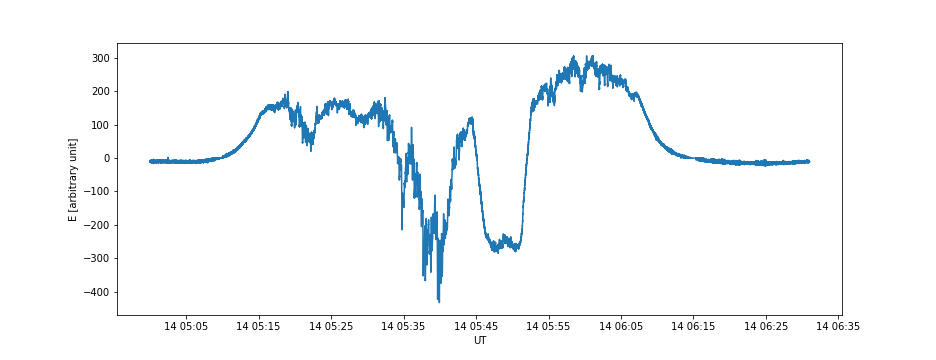

In [87]:
%matplotlib notebook

df['time'] = pd.to_datetime(pd.to_datetime('2019-07-12 14:40') + pd.to_timedelta(df.index*0.1133846790509479, unit='s'))

rc = df
rc = rc.set_index(['time'])

rc = rc.loc['2019-07-14 5:00':'2019-07-14 6:30']

plt.figure(figsize=(13,5))
plt.plot(rc[2])
#plt.locator_params(axis='x',nbins=40)
plt.xlabel('UT')
plt.ylabel('E [arbitrary unit]')

plt.show()

In [50]:
#df6.loc[df6['lat']>49.194991].loc[df6['lat']<49.194992].loc[df6['lon']>14.63983].loc[df6['lon']<14.63984]
df6.loc['2019-08-29 14:00':'2019-08-29 14:20']

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,altitude,speed,run,lat,lon
date,,,,,,,,,,,,,,,,,,,,,
2019-08-29 14:00:01,$MPL,140,1437,0,99590.50,25.38,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,199.3,0.002,1.0,50.245258,14.368401
2019-08-29 14:00:11,$MPL,141,1447,2,99574.25,25.31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,199.1,0.012,1.0,50.245260,14.368398
2019-08-29 14:00:16,$STROKE,62,1451,0x1C,0x22,0xC2,0x04,0x00,0x00,0x00,...,NaN,NaN,NaN,NaN,NaN,198.6,0.022,1.0,50.245260,14.368395
2019-08-29 14:00:16,$STROKE,63,1451,0x1C,0x22,0xC2,0x04,0x00,0x00,0x00,...,NaN,NaN,NaN,NaN,NaN,198.6,0.022,1.0,50.245260,14.368395
2019-08-29 14:00:22,$MPL,142,1457,0,99592.00,25.19,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,198.6,0.022,1.0,50.245260,14.368395
2019-08-29 14:00:32,$MPL,143,1467,2,99604.75,25.06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,198.4,0.032,1.0,50.245259,14.368392
2019-08-29 14:00:36,$STROKE,64,1471,0x1C,0x22,0xC2,0x08,0xA4,0x4F,0x00,...,NaN,NaN,NaN,NaN,NaN,198.5,0.032,1.0,50.245260,14.368391
2019-08-29 14:00:43,$MPL,144,1478,0,99597.50,25.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,198.5,0.032,1.0,50.245260,14.368391
2019-08-29 14:00:50,$STROKE,65,1485,0x1C,0x22,0xC2,0x00,0x18,0x45,0x00,...,NaN,NaN,NaN,NaN,NaN,198.0,0.020,1.0,50.245260,14.368390
